# Windspeed Analysis for Windfarm
***


Ireland’s abundant wind resources make it an ideal candidate for harnessing wind energy, a key component in the country’s transition to renewable energy. This project focuses on analyzing wind speed data from a specific location in Ireland,  utilizing historical weather data from Met Éireann and other credible sources. By examining trends and patterns in hourly collected wind speed data over different timeframes daily, monthly, and yearly—this analysis aims to assess the potential for wind energy generation near Mace Head in Galway. Additionally, it considers operational factors, such as the minimum and maximum wind speeds at which wind turbines operate, to evaluate the feasibility and efficiency of wind farm operations.

The analysis also delves into long-term trends in wind speeds to assess whether they are consistent or show significant changes over the decades, providing insights into future wind energy potential. Beyond wind speed, other weather metric such as temperature will be explored to understand its impact on wind farm efficiency. This project will also explore the challenges of forecasting wind power output by leveraging available weather predictions and wind turbine power curves. Ultimately, the findings will provide actionable insights for optimizing wind farm development and contribute to Ireland’s renewable energy goals.

## Met Eireann Station

The west coast of Ireland, encompassing counties such as Donegal, Mayo, Galway, and Clare, is the ideal region for wind speed analysis due to its exposure to strong and consistent Atlantic winds, making it one of the most productive areas for wind energy generation. With high average wind speeds year-round and significant potential for both onshore and offshore wind farms, this region offers unparalleled opportunities for efficient and sustainable wind power development. Its proven track record, exemplified by successful projects like the Galway Wind Park, further underscores its suitability as a focal point for wind speed analysis and wind farm optimization [[57]](57).
For this project the county of Galway and more specific the Met Eireann station in Mace Head was chosen to have the wind speed analysed for windfarm as it is one of the few stations in Galway that presents hourly data of some parameters such as the Mean Wind Speed (kt) and Air Temperature (C) since 2003, which will be beneficial for the analysis to be carried out as part of this project.

## Read in data

In this section, the appropriate modules are imported, the data is read in and an analysis is completed to have an overview of the data.

In [26]:
# Import pandas

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

import seaborn as sns

import calendar

In [27]:
# Wind turbine models and specifications
turbine_data = {
    'Vestas V52': {'cut_in': 4.0, 'rated': 14.0, 'cut_out': 25.0, 'count': 70, 'rated_power': 0.85},
    'Siemens SWT-3.0-101': {'cut_in': 3.5, 'rated': 14.5, 'cut_out': 25.0, 'count': 58, 'rated_power': 3.0},
    'Nordex N149 4.0-4.5': {'cut_in': 3.0, 'rated': 12.0, 'cut_out': 20.0, 'count': 15, 'rated_power': 4.0},
    'Nordex N149 5.0': {'cut_in': 3.0, 'rated': 12.5, 'cut_out': 26.0, 'count': 7, 'rated_power': 5.0}
}

# Calculate the weighted average for a given parameter
def weighted_average(data, param):
    total_weight = sum(turbine['count'] for turbine in data.values())
    return sum(turbine[param] * turbine['count'] for turbine in data.values()) / total_weight

# Calculate optimum values
opt_cut_in = weighted_average(turbine_data, 'cut_in')
opt_rated = weighted_average(turbine_data, 'rated')
opt_cut_out = weighted_average(turbine_data, 'cut_out')
opt_rated_power = weighted_average(turbine_data, 'rated_power')

# Print results
print(f"Optimum Cut-in Wind Speed: {opt_cut_in:.2f} m/s")
print(f"Optimum Rated Wind Speed: {opt_rated:.2f} m/s")
print(f"Optimum Cut-out Wind Speed: {opt_cut_out:.2f} m/s")
print(f"Optimum Rated Power: {opt_rated_power:.2f} MW")


Optimum Cut-in Wind Speed: 3.66 m/s
Optimum Rated Wind Speed: 13.92 m/s
Optimum Cut-out Wind Speed: 24.55 m/s
Optimum Rated Power: 2.19 MW


Looking at the file hly275.csv downloaded from [Met Eireann website](https://www.met.ie/climate/available-data/historical-data) and saved into the project folder is noticeable that there are 17 rows that needs to be removed to allow proper analysis of the data [[58]](58).

In [28]:
# Read in Data and skip rows 17

file = 'hly275.csv'

df = pd.read_csv(file,skiprows=17)

/var/folders/rk/fh00kl713wq4442gfb60yzk40000gn/T/ipykernel_11981/1798932155.py:5: DtypeWarning: Columns (2,4,6,7,8,9,10,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file,skiprows=17)


In [29]:
# Quick look into the first 5 rows

df.head()

,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,msl,ind.3,wdsp,ind.4,wddir
0,13-aug-2003 01:00,-1,,4,,4,,,,,,7,,7,
1,13-aug-2003 02:00,-1,,4,,4,,,,,,7,,7,
2,13-aug-2003 03:00,-1,,4,,4,,,,,,7,,7,
3,13-aug-2003 04:00,-1,,4,,4,,,,,,7,,7,
4,13-aug-2003 05:00,-1,,4,,4,,,,,,7,,7,


The first 5 rows show a lot of null data including wdsp (mean windspeed). Therefore let's have a look at the number of 'NaN' values in this dataset.

In [30]:
# Confirming the count of Non-null data and data type

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186744 entries, 0 to 186743
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    186744 non-null  object
 1   ind     186744 non-null  int64 
 2   rain    186744 non-null  object
 3   ind.1   186744 non-null  int64 
 4   temp    186744 non-null  object
 5   ind.2   186744 non-null  int64 
 6   wetb    186744 non-null  object
 7   dewpt   186744 non-null  object
 8   vappr   186744 non-null  object
 9   rhum    186744 non-null  object
 10  msl     186744 non-null  object
 11  ind.3   186744 non-null  int64 
 12  wdsp    186744 non-null  object
 13  ind.4   186744 non-null  int64 
 14  wddir   186744 non-null  object
dtypes: int64(5), object(10)
memory usage: 21.4+ MB


From df.info() it does not seem to have null data which goes against what we have just seend in the first 5 rows and that might be due to the data type. Therefore let's check the number of unique values in 'wdsp' column.

In [31]:
# See all unique values in the column 'wdsp'

print(df['wdsp'].unique())  

[' ' '6' '4' '3' '5' '7' '9' '12' '10' '8' '2' '1' '11' '13' '16' '17'
 '19' '22' '25' '23' '14' '18' '20' '21' '15' '24' '26' '30' '28' '29'
 '27' '33' '36' '31' '32' '34' '37' '42' '44' '40' '35' '38' '39' '41'
 '43' '53' '50' '48' '47' '46' '0' '45' '51' '52' '49' '56' '55' 17 18 15
 14 11 6 5 3 4 8 9 12 13 16 7 2 10 20 23 21 22 19 25 26 28 29 27 24 30 1
 31 35 37 34 41 51 55 56 45 40 36 33 32 39 42 38 46 43 47 49 44 50 0 54 48
 52]


From the output of unique values function above is possible to see that the data type in this column is mixed, showing string and numeric data types. Also, there is null data, so let's clean the data.

## Clean the dataset

In this section, we replace and clean null data, then convert all the string data in column 'wdsp' to integer. We also normalise the datetime data to 'YYYY-MM-DD hh:mm:ss'.

### Replace null values

In [32]:
# Replace non-numeric or invalid values with NaN

df['wdsp'] = df['wdsp'].replace([' ', '', 'NA', 'null'], np.nan)

In [33]:
# Count NaN values in 'wdsp'
nan_wdsp_count = df['wdsp'].isnull().sum()

print(f"Number of NaN values in 'wdsp': {nan_wdsp_count}")

Number of NaN values in 'wdsp': 1296


### Change data type

In [34]:
# Convert 'wdsp' to integer, coercing non-convertible values to NaN

df['wdsp'] = pd.to_numeric(df['wdsp'], errors='coerce').astype('Int64') 

# Verify the data types

print(df['wdsp'].dtypes)

Int64


In [35]:
# Check the first few rows for 'date' and 'wdsp' columns

print(df[['date', 'wdsp']].head())

                date  wdsp
0  13-aug-2003 01:00  <NA>
1  13-aug-2003 02:00  <NA>
2  13-aug-2003 03:00  <NA>
3  13-aug-2003 04:00  <NA>
4  13-aug-2003 05:00  <NA>


### Drop NaN

In [36]:
# Drop rows where 'wdsp' is NaN
df = df.dropna(subset=['wdsp'])

# Verify if NaN values are removed
null_wdsp_count = df['wdsp'].isna().sum()
print(f"Number of NaN values in 'wdsp' after dropping: {null_wdsp_count}")

Number of NaN values in 'wdsp' after dropping: 0


### Normalise datetime

In [37]:
# Change date time format

df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

df['date']

24       2003-08-14 01:00:00
25       2003-08-14 02:00:00
26       2003-08-14 03:00:00
27       2003-08-14 04:00:00
28       2003-08-14 05:00:00
                 ...        
186739   2024-11-30 20:00:00
186740   2024-11-30 21:00:00
186741   2024-11-30 22:00:00
186742   2024-11-30 23:00:00
186743   2024-12-01 00:00:00
Name: date, Length: 185448, dtype: datetime64[ns]

Note: the column 'date' contains Date and Time in UTC time zone, so no further action required here.

## Wind power in Mace Head - Galway

To determine the wind power available in Mace Head the variability of wind speeds and the operational characteristics of wind turbines are taken into consideration.

For this project hourly mean wind speeds will be used instead of aggregating into daily, monthly and yearly as they preserve much of the variability.

The wind power is calculated as per formula below [[59]](59):

$P = 0.5 C_p \rho \pi R^2 V^3$

where:
- $Cp$ is the coefficient of performance (efficiency factor, $\%$)
- $ρ$ is air density ($kg/m3$)
- $R$ is the radius of the wind turbine ($m$)
- $V$ is the wind speed ($m/s$).


### Turbine Operational Ranges

In County Galway, Vestas V52 is the most commonly used turbine in wind farms, accounting for 70 out of 192 turbines currently confirmed as operational [[60]](60). In the table below is possible to see the specification for this turbine model [[61]](61).

| **Wind Turbine Model**     | **Cut-in Wind Speed** | **Rated Wind Speed** | **Cut-out Wind Speed** | **Rated Power** | **Efficiency** | **Rotor Diameter** |
|----------------------------|-----------------------|----------------------|------------------------|----------------|----------------|--------------------|
| **Vestas V52**              | 4.0 m/s               | 14 m/s               | 25.0 m/s               | 0.85 MW        | 45%            | 52.0 m            |

### Wind Power Calculation for Vestas V52

To calculate the power output of a wind turbine like the Vestas V52 considering its operational wind speed range (cut-in, rated, and cut-out wind speeds), the formula can be divided into four distinct regions [[62]](62):

1. Below Cut-in Wind Speed:    
$V < V_{cut-in}$.   
The turbine produces no power:    
$P = 0$

2. Between Cut-in and Rated Wind Speed:   
$V_{\text{cut-in}} \leq V < V_{\text{rated}}$    
The power output increases with the cube of the wind speed:   
$P = 0.5 C_p \rho \pi R^2 V^3$.     

3. Between Rated and Cut-out Wind Speed:   
$V_{\text{rated}} \leq V < V_{\text{cut-out}}$  
The turbine operates at constant rated power:    
$P = P_{\text{rated}}$  

4. Above Cut-out Wind Speed:   
$V \geq V_{\text{cut-out}}$  
The turbine is shut down for safety, and the power is:  
$P = 0$

Using these regions, we can calculate the turbine's output for a specific wind speed V.
From Vestas V52 turbine specification we have:

In [38]:
# Vestas V52 Specification
speed_cut_in = 4.0  # m/s
speed_rated = 14.0  # m/s
speed_cut_out = 25.0  # m/s
power_rated = 0.85 * 10**6  # Watts (MW converted to Watts)
efficiency = 0.45 # coefficient of performance
rotor_diameter = 52.0 # m

Air density is also required for the wind power calculation. The air density is a standard value [[63]](63):

$ρ = 1.225 kg/m^3$  

Therefore, this is also added to the script:

In [39]:
# Air Density
air_density = 1.225  # kg/m³ (standard)

The wind speed in column 'wdsp' of the dataset is given in $knot$ and needs to be converted to $m/s$ [[64]](64):

$1 knot = 0.514 m/s$

Let's create a column in the data frame with the converted value.

In [40]:
# Convert knots to m/s
knot_to_ms = 0.51444  # m/s

# Create column in df with unit in m/s
df['wdsp_ms'] = df['wdsp'] * knot_to_ms

# Confirming the first 5 rows of this new column
df['wdsp_ms'].head()

24    3.08664
25    2.05776
26    1.54332
27     2.5722
28    3.08664
Name: wdsp_ms, dtype: Float64

The rotor is giving in diameter and this needs to be changed to radius [[65]](65). To do that we use the formula:

$r = \frac{d}{2}$

And then we also calculate the rotor area which is this part $\rho \pi R^2$ of the formula $P = 0.5 C_p \rho \pi R^2 V^3$.

In [41]:
# Convert diameter to radius
rotor_radius = rotor_diameter / 2

print (f'The rotor radius is {rotor_radius} m')

# Calculate the rotor area
rotor_area = np.pi * (rotor_radius ** 2)

print(f'The rotor area is {rotor_area:.2f} m²')

The rotor radius is 26.0 m
The rotor area is 2123.72 m²


With all the constants values determined we can now define the function to calculate wind power based on wind speed:

In [42]:
# Function to calculate power
def calculate_wind_power(wind_speed):
    if wind_speed < speed_cut_in or wind_speed > speed_cut_out:
        return 0
    elif wind_speed < speed_rated:
        rotor_area = np.pi * (40 ** 2)
        return 0.5 * air_density * rotor_area * (wind_speed ** 3) * efficiency
    else:
        return power_rated

Next, we use the function to create a column in the data frame called 'wdpr' (Wind Power in Watts):

In [43]:
# Create column wdpr
df['wdpr'] = df['wdsp_ms'].apply(calculate_wind_power)

With the Wind Power column added to the dataset now we can calculate the following:

- Total Power. 
- The mean wind power per hour.

Note: This is the total power and average power per hour that could have been generated since the station started collecting the wind speed data (13-aug-2003). This is hypotethical scenario considering that the mean wind speed is constant during the whole hour. This scenario does not reflect the reality. 

In [44]:
# Total power in Watts
total_power = df['wdpr'].sum()  

# Convert Watts to GW for reporting
total_power_gw = total_power / 10**9

# Print results
print(f"Total wind power over the period: {total_power_gw:.2f} GW")

Total wind power over the period: 140.45 GW


In [45]:
# Mean power in Watts
mean_power = df['wdpr'].mean()  

# Convert Watts to MW for reporting
mean_power_mw = mean_power / 10**6

# Print results
print(f"Mean wind power per hour: {mean_power_mw:.2f} MW")

Mean wind power per hour: 0.76 MW


Further, we analyze wind power availability across different times of the day and year, we can break down the data into categories such as hourly, daily, monthly, and seasonal trends.

1. Add Time of Day and Year Columns
Extract the time and month information from the date column to facilitate grouping by time of day or time of year.

In [46]:
# Extract hour, month, and season from the 'date' column
df['hour'] = df['date'].dt.hour
df['month'] = df['date'].dt.month

# Define Irish calendar seasons
irish_seasons = {
    2: 'Spring', 3: 'Spring', 4: 'Spring',
    5: 'Summer', 6: 'Summer', 7: 'Summer',
    8: 'Autumn', 9: 'Autumn', 10: 'Autumn',
    11: 'Winter', 12: 'Winter', 1: 'Winter'
}

# Map months to Irish seasons
df['season'] = df['month'].map(irish_seasons)

Group Data for Analysis

Group the data by hour, month, or season to analyze wind power generation trends at different times of day or year.

Hourly Analysis

In [47]:
# Calculate average wind power for each hour of the day
hourly_power = df.groupby('hour')['wdpr'].mean()

# Convert to MW for better readability
hourly_power_mw = hourly_power / 10**6

Result:

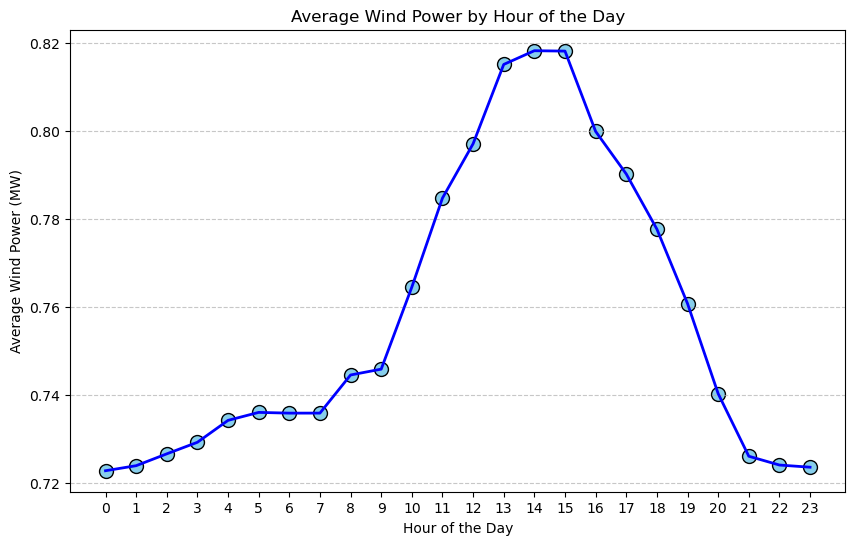

In [56]:
# Assuming hourly_power_mw is already defined
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(hourly_power_mw.index, hourly_power_mw.values, color='skyblue', edgecolor='black', s=100)

# Line plot connecting the points
plt.plot(hourly_power_mw.index, hourly_power_mw.values, color='blue', linewidth=2)

# Titles and labels
plt.title('Average Wind Power by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Wind Power (MW)')

# Set x-axis labels to be integers (hour)
plt.xticks(ticks=range(24), labels=[str(i) for i in range(24)], rotation=0)

# Add gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

Monthly Analysis

In [51]:
# Calculate average wind power for each month
monthly_power = df.groupby('month')['wdpr'].mean()

# Convert to MW
monthly_power_mw = monthly_power / 10**6

Result:

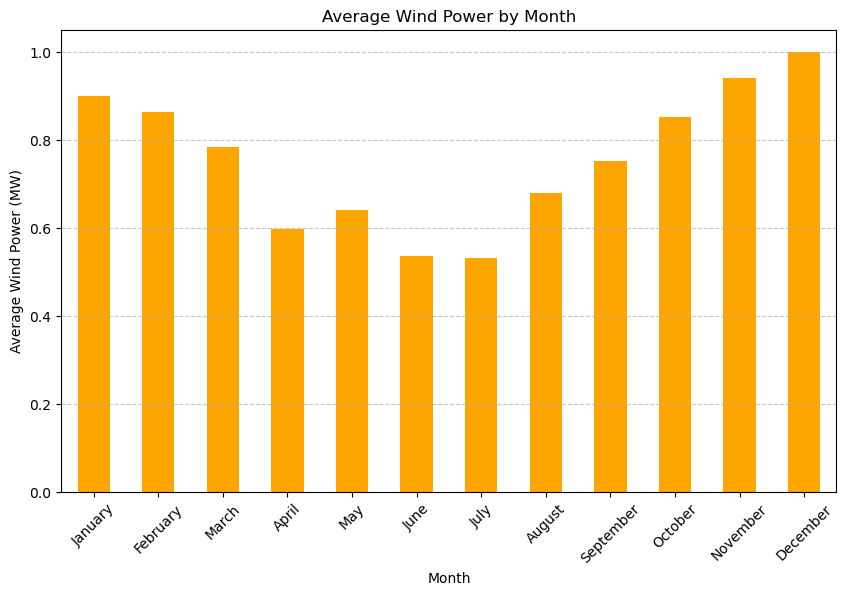

In [52]:
plt.figure(figsize=(10, 6))
monthly_power_mw.plot(kind='bar', color='orange')
plt.title('Average Wind Power by Month')
plt.xlabel('Month')
plt.ylabel('Average Wind Power (MW)')
plt.xticks(range(12), calendar.month_name[1:13], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Seasonal Analysis

In [53]:
# Calculate average wind power for each season
seasonal_power = df.groupby('season')['wdpr'].mean()

# Convert to MW
seasonal_power_mw = seasonal_power / 10**6
print(seasonal_power_mw)


season
Autumn    0.761967
Spring    0.747169
Summer    0.570209
Winter    0.946856
Name: wdpr, dtype: float64


Result:

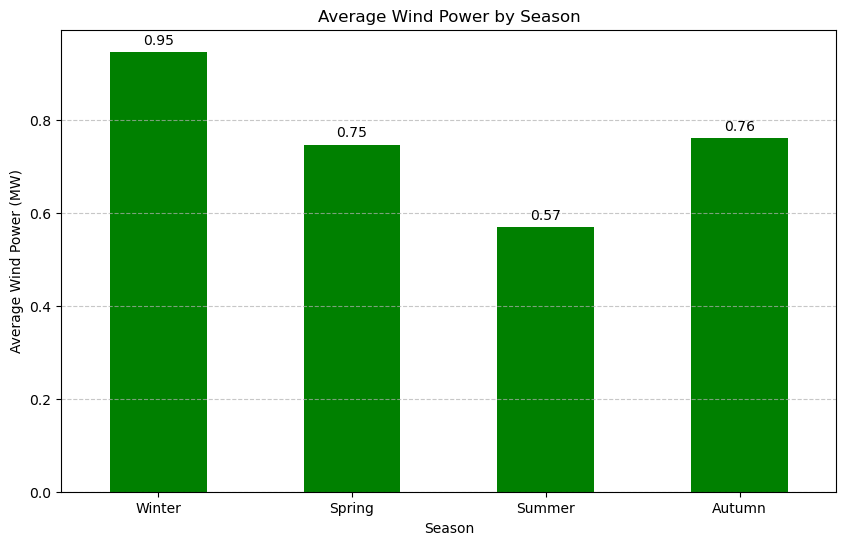

In [58]:
# Ensure that the seasonal_power_mw has the correct order (Winter, Spring, Summer, Autumn)
season_order = ['Winter', 'Spring', 'Summer', 'Autumn']
seasonal_power_mw = seasonal_power_mw[season_order]

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot with the defined order of seasons
ax = seasonal_power_mw.plot(kind='bar', color='green')

# Title and labels
plt.title('Average Wind Power by Season')
plt.xlabel('Season')
plt.ylabel('Average Wind Power (MW)')

# Set x-ticks to the season order
plt.xticks(ticks=range(4), labels=season_order, rotation=0)

# Add gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add bar labels (values) on top of each bar
for i, v in enumerate(seasonal_power_mw):
    ax.text(i, v + 0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=10, color='black')

# Show the plot
plt.show()


***
# End